In [1]:
# pip install pandas
# pip install matplotlib
# pip install statsmodels
# pip install sklearn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
from statsmodels.tsa.statespace.sarimax import SARIMAX # SEASONALITY ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose # 데이터의 계절성 확인
from statsmodels.tsa.stattools import acf # 자기상관함수
from statsmodels.tsa.stattools import pacf # 편자기상관함수


from sklearn.metrics import mean_squared_error # 오차값 구하는 함수

import itertools

import warnings
warnings.filterwarnings("ignore")

# ARIMA 모델링

In [2]:
# 데이터 확인

df = pd.read_csv('HTrain.csv' )
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df['total'].plot()
plt.title('Total Export')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'HTrain.csv'

Text(0.5, 1.0, 'Residual')

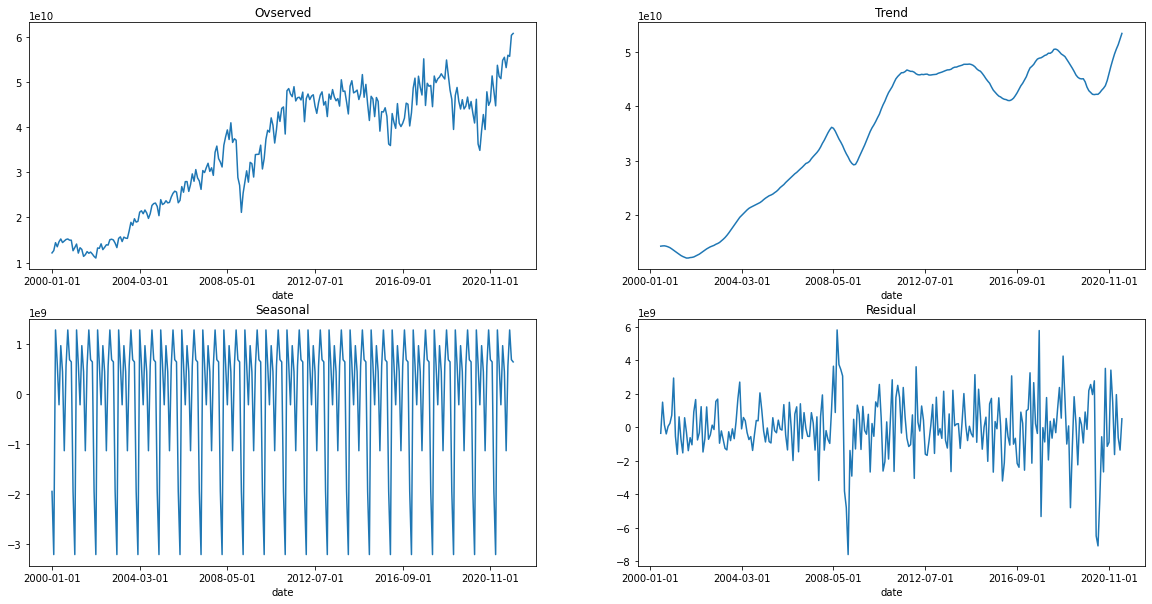

In [ ]:
# raw 현황분석

total = df['total']
decomposition = seasonal_decompose(total, model='additive', freq=12)

fig, ax = plt.subplots(2,2, figsize=(20,10))

# 현황
decomposition.observed.plot(ax=ax[0][0])
ax[0][0].set_title('Ovserved')

# 추세
decomposition.trend.plot(ax=ax[0][1])
ax[0][1].set_title('Trend')

# 계절성
decomposition.seasonal.plot(ax=ax[1][0])
ax[1][0].set_title('Seasonal')

# 잔차
decomposition.resid.plot(ax=ax[1][1])
ax[1][1].set_title('Residual')


# 추세 : 우상향, 계절성 : 포함, 잔차 : 불규칙적

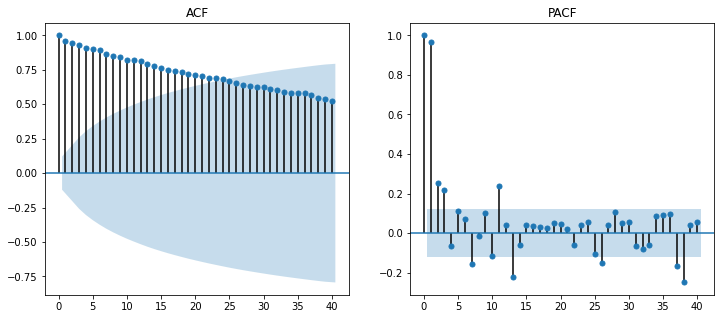

In [51]:
# 정상성 여부 파악

fig, ax = plt.subplots(1,2, figsize=(12,5))

# 자기상관함수
sm.graphics.tsa.plot_acf(total.squeeze(), lags=40, ax=ax[0])
ax[0].set_title('ACF')

# 편자기상관함수
sm.graphics.tsa.plot_pacf(total.squeeze(), lags=40, ax=ax[1])
ax[1].set_title('PACF')

plt.show()



In [52]:
# 비정상성 그래프로 판단 후 차분진행

diff_total = total.copy()
diff_total = diff_total.diff()
diff_total = diff_total.dropna()

print('차분 전 수치')
print(total)
print('-------------------------')
print('차분 후 수치')
print(diff_total)



차분 전 수치
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
-------------------------
차분 후 수치
date
2000-02-01     513617672.00000
2000-03-01    1753660782.00000
2000-04-01    -907663069.00000
2000-05-01    1114714954.00000
2000-06-01     614184685.00000
                    ...       
2021-08-01   -2296414373.00000
2021-09-01    2748758589.00000
2021-10-01    -253489738.00000
2021-11-01    4670169626.00000
2021-12-01     403574407.00000
Name: total, Length: 263, dtype: float64


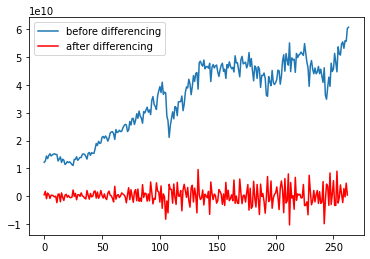

In [53]:
# 원데이터와 차분 후 데이터 비교

plt.plot(total.values, label='before differencing')
plt.plot(diff_total.values, 'r', label='after differencing')

plt.legend()
plt.show()


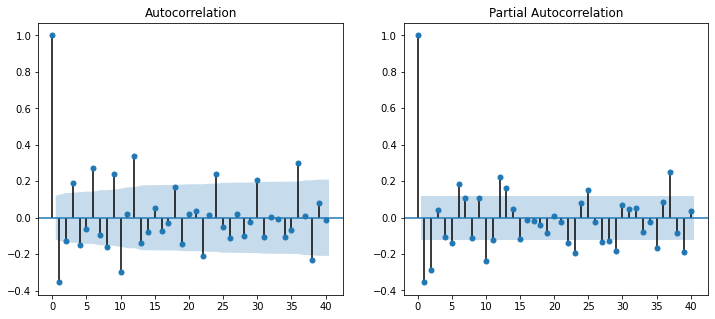

In [54]:
# 차분 후 자기상관함수와 편자기상관함수 그래프

fig, ax = plt.subplots(1,2, figsize=(12,5))

sm.graphics.tsa.plot_acf(diff_total.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_total.values.squeeze(), lags=40, ax=ax[1])
plt.show()

# 1차 차분후 정상성 데이터로 확인

In [55]:
# Graphical Method 로 찾은 임의의 order값 (1,1,1)로 모델링

model = ARIMA(total.values ,order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6087.818
Method:                       css-mle   S.D. of innovations     2731587737.220
Date:                Thu, 04 Aug 2022   AIC                          12183.637
Time:                        02:17:18   BIC                          12197.925
Sample:                             1   HQIC                         12189.379
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.847e+08    8.5e+07      2.173      0.031    1.81e+07    3.51e+08
ar.L1.D.y      0.0518      0.115      0.451      0.652      -0.173       0.277
ma.L1.D.y     -0.5240      0.095     -5.517      0.000      -0.710      -0.338
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           19.3199           +0.0000j           19.3199            0.0000
MA.1            1.9085           +0.0000j            1.9085            0.0000
-----------------------------------------------------------------------------
"""

In [56]:
##  Grid Search (AIC 낮은 모델의 order 값 찾기)

import itertools
p=range(3)
d=range(1,2)
q=range(3)
pdq = list(itertools.product(p,d,q))

aic = []

for i in pdq:
  try:
    model = ARIMA(total.values, order=(i))
    model_fit = model.fit()
    print(str(i), '=', str(round(model_fit.aic, 2)))

    aic.append(model_fit.aic)
  except:
    continue

print(min(aic))

(0, 1, 0) = 12232.6
(0, 1, 1) = 12181.84
(0, 1, 2) = 12183.52
(1, 1, 0) = 12199.36
(1, 1, 1) = 12183.64
(2, 1, 0) = 12178.53
(2, 1, 1) = 12179.85
(2, 1, 2) = 12181.54
12178.52858537056


In [57]:
# Grid Search 로 찾은 order 적용

model = ARIMA(total.values ,order=(2,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6085.264
Method:                       css-mle   S.D. of innovations     2704985822.729
Date:                Thu, 04 Aug 2022   AIC                          12178.529
Time:                        02:17:19   BIC                          12192.817
Sample:                             1   HQIC                         12184.271
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.847e+08   9.58e+07      1.928      0.055   -3.07e+06    3.72e+08
ar.L1.D.y     -0.4564      0.059     -7.737      0.000      -0.572      -0.341
ar.L2.D.y     -0.2888      0.059     -4.887      0.000      -0.405      -0.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7901           -1.6846j            1.8607           -0.3198
AR.2           -0.7901           +1.6846j            1.8607            0.3198
-----------------------------------------------------------------------------
"""

In [58]:
# 원데이터의 마지막 6개월 예측  (2021.07 ~ 2021.12)

pred = model_fit.forecast(6)
pred_values = pred[0]
pred_index = df.index[-6:]

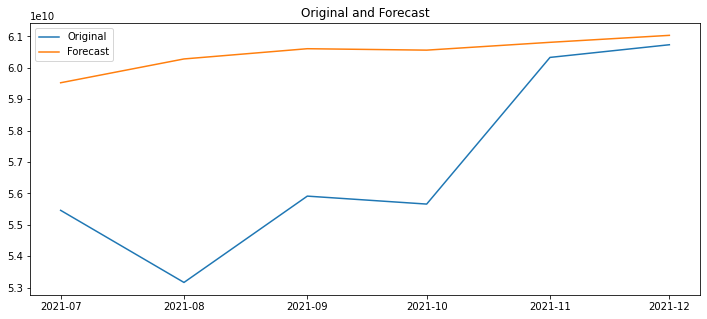

총 수출액으로만 예측한 모델의 RMSE : 4349779213
[5.95233255e+10 6.02817366e+10 6.06076084e+10 6.05621350e+10
 6.08110910e+10 6.10329147e+10]


In [59]:
real_values = df['2021-07-01':]['total']

plt.subplots(figsize=(12,5))
plt.plot(pred_index, real_values, label='Original')
plt.plot(pred_index, pred_values, label='Forecast')
plt.title('Original and Forecast')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(real_values, pred_values))
print('총 수출액으로만 예측한 모델의 RMSE : {}'.format(int(rmse)))
print(pred_values)

## 계절성 order 값 포함 Grid Search

In [60]:
# 계절성 ARIMA 모델사용

p = d = q = range(0, 2)
pdq = list( itertools.product(p, d, q))
seasonal_pdq = [ (x[0], x[1], x[2], 12)  for x in pdq ]


aic = 10000000
temp_order = 0
temp_sorder = 0

for ord in pdq:
  for seasonal_ord in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(total.values,
                                        order = ord,
                                        seasonal_order = seasonal_ord)
      
      result = model.fit()
      print(result.aic)
      if result.aic < aic:
        aic = result.aic
        temp_order = ord
        temp_sorder = seasonal_ord

    except:
      continue

print('Order : {}, Seasonal_Order : {}'.format(temp_order, temp_sorder))

Order : (1, 1, 0), Seasonal_Order : (0, 1, 1, 12)


In [61]:
# Grid Search 로 찾은 order, seasonal_order 로 모델링
model = SARIMAX(total.values ,order=(1,1,0), seasonal_order=(0,1,1,12))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  264
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -5795.695
Date:                            Thu, 04 Aug 2022   AIC                          11597.390
Time:                                    02:17:44   BIC                          11607.966
Sample:                                         0   HQIC                         11601.646
                                            - 264                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4070      0.079     -5.121      0.000      -0.563      -0.251
ma.S.L12      -0.7660      0.073    -10.451      0.000      -0.910      -0.622
sigma2      9.555e+18   2.57e-21   3.72e+39      0.000    9.56e+18    9.56e+18
===================================================================================
Ljung-Box (Q):                       76.77   Jarque-Bera (JB):                87.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.98   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.09e+54. Standard errors may be unstable.
"""

In [62]:
# 원데이터의 마지막 6개월 예측  (2021.07 ~ 2021.12)

pred = model_fit.get_forecast(6)
pred_values = pred.predicted_mean
pred_index = df.index[-6:]


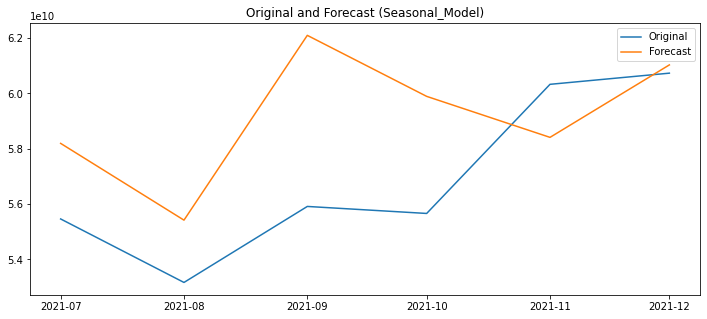

계절성 모델의 RMSE : 3476938647
[5.81947730e+10 5.54184661e+10 6.21014558e+10 5.98948358e+10
 5.84122158e+10 6.10329868e+10]


In [63]:
plt.subplots(figsize=(12,5))

real_values = df['2021-07-01':]['total']
plt.plot(pred_index, real_values, label='Original')
plt.plot(pred_index, pred_values, label='Forecast')
plt.title('Original and Forecast (Seasonal_Model)')
plt.legend()
plt.show()

rmse_seasonal = np.sqrt(mean_squared_error(real_values, pred_values))
print('계절성 모델의 RMSE : {}'.format(int(rmse_seasonal)))
print(pred_values)
# 계절성 적용한 모델이 오차가 더 적음

## 5개국 (중국, 미국, 베트남, 홍콩, 일본) 포함 예측

In [64]:
df = pd.read_csv('HTrain.csv')
df = df.set_index('date')


# 총 수출액
total = df['total']

# 최종 csv 파일에는 기타 변수가 모두 포함되어 있으므로 5개국 이외의 변수 drop

# 5개국 수출액
exog = df.drop(['total','ex_rate', 'oecd_index','korea_index','oil'], axis=1) 


print('----------------------total---------------------')
print(total)
print('----------------------exog1---------------------')
print(exog)


----------------------total---------------------
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
----------------------exog1---------------------
                  china         usa     vietnam    hongkong       japan
date                                                                   
2000-01-01   1235215271  2609787984   109742698   782348732  1551722070
2000-02-01   1273117309  2554309883   112395157   823990122  1518844843
2000-03-01   1437377223  2946820669   150134562   911648256  1783564618
2000-04-01   1366876604  2698029849   169146208   863243219  1582707525
2000-05-01   1663240667  3167181403   169411680   887081090  1671039709
...                 ...         ...         ...         ...         

# 함수 정의(2021.7 - 2021.12 까지 예측)
-Gird Search 포함 (변수 : 5개국)


In [65]:
p = d = q = range(0, 2)
pdq = list( itertools.product(p, d, q))

seasonal_pdq = [ (x[0], x[1], x[2], 12)  for x in pdq ]


# 총 수출액, 변수, 모델링에서 제외시킬 나라 (또는 변수) 를 받는 예측함수 정의

def predict1(total, exog, not_used_country):
  global rmse, real_values, pred_values
  aic = 10000000
  temp_order = 0
  temp_sorder = 0

  if not_used_country == None:
    pass
  else:
    exog = exog.drop(not_used_country, axis=1)

  for ord in pdq:
    for seasonal_ord in seasonal_pdq:
      try:
        model = sm.tsa.statespace.SARIMAX(total.values,
                                          order = ord,
                                          seasonal_order = seasonal_ord)
        
        result = model.fit()


        if result.aic < aic:
          aic = result.aic
          temp_order = ord
          temp_sorder = seasonal_ord


      except:
        continue

  print(temp_order, temp_sorder, aic)

  model = SARIMAX(total.values[:-6],
                  exog=exog[:-6],
                  order=temp_order,
                  seasonal_order=temp_sorder)
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean
  
  real_values = total.values[-6:]

  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))
  

In [66]:
# 모든 나라를 포함시키기 때문에 3번째 값은 None (제외할 나라 없음)
predict1(total, exog, None)

(1, 1, 0) (0, 1, 1, 12) 11597.389605807868
RMSE : 1252287917


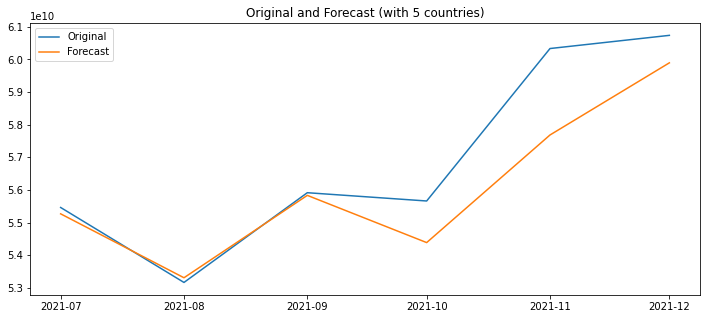

5개국의 수출액을 변수로 사용한 모델의 RMSE : 1252287917.953671


In [67]:
plt.subplots(figsize=(12,5))

real_values = df['2021-07-01':]['total']
plt.plot(pred_index, real_values, label='Original')
plt.plot(pred_index, pred_values, label='Forecast')
plt.title('Original and Forecast (with 5 countries)')
plt.legend()
plt.show()

print('5개국의 수출액을 변수로 사용한 모델의 RMSE : {}'.format(rmse))

In [68]:
# Grid Search 로 찾은 3개의 order, seasonal_order 조합중 RMSE가 가장 낮았던 (1,1,0) (1,1,1,12) 사용

def predict2(total, exog, not_used_cols):
  global rmse, real_values, pred_values
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

  
  model = SARIMAX(total[:-6],
                  exog=exog[:-6],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))

In [69]:
predict2(total, exog, None)

RMSE : 1068324023


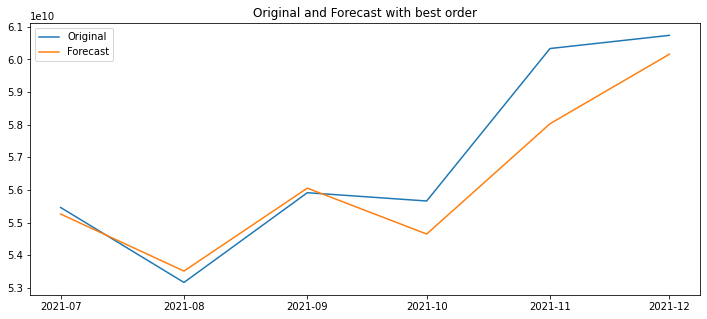

선정한 3개의 order값중 가장 오차가 적은 모델의 RMSE : 1068324023.0071384


In [70]:
plt.subplots(figsize=(12,5))

real_values = df['2021-07-01':]['total']
plt.plot(pred_index, real_values, label='Original')
plt.plot(pred_index, pred_values, label='Forecast')
plt.title('Original and Forecast with best order')
plt.legend()
plt.show()

print('선정한 3개의 order값중 가장 오차가 적은 모델의 RMSE : {}'.format(rmse))

## 기타 변수 포함 (환율, 유가, 한국 경기선행지수, OECD 경기선행지수)
### 변수 : 5개국 + 기타 변수

In [71]:
df = pd.read_csv('HTrain.csv')
df = df.set_index('date')

# 총 수출액
total = df['total']


# 5개국 수출액과 기타 변수
exog = df.drop(['total'], axis=1)

print('----------------------total---------------------')
print(total)
print('----------------------exog1---------------------')
print(exog)


----------------------total---------------------
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
----------------------exog1---------------------
                  china         usa     vietnam    hongkong       japan  \
date                                                                      
2000-01-01   1235215271  2609787984   109742698   782348732  1551722070   
2000-02-01   1273117309  2554309883   112395157   823990122  1518844843   
2000-03-01   1437377223  2946820669   150134562   911648256  1783564618   
2000-04-01   1366876604  2698029849   169146208   863243219  1582707525   
2000-05-01   1663240667  3167181403   169411680   887081090  1671039709   
...                 ...         ...         ...

## - RMSE 가 가장 낮았던 유가와 한국 경기선행지수만 변수로 사용
### 변수 : 5개국, 유가, 경기선행지수(한국)

In [72]:
def predict3(total, exog, not_used_cols):
  global rmse, real_values, pred_values
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

  # Grid Search 로 찾은 3개의 order, seasonal_order 조합중 가장 RMSE 가 낮았던 값 사용
  model = SARIMAX(total[0:-6],
                  exog=exog[0:-6],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))

In [73]:
# 사용하지 않을 경기선행지수(OECD) 와 환율 제외
predict3(total, exog, ['oecd_index', 'ex_rate'])

RMSE : 996403053


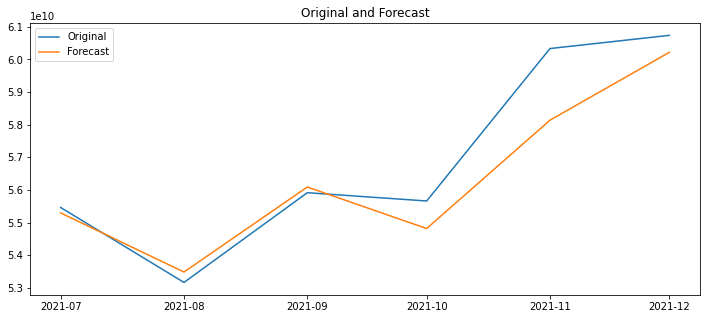

5개국및 기타변수 2개 사용한 모델의 RMSE : 996403053.5247461


In [74]:
# 5개국 및 기타 변수 포함
plt.subplots(figsize=(12,5))

real_values = df['2021-07-01':]['total']
plt.plot(pred_index, real_values, label='Original')
plt.plot(pred_index, pred_values, label='Forecast')
plt.title('Original and Forecast')
plt.legend()
plt.show()

print('5개국및 기타변수 2개 사용한 모델의 RMSE : {}'.format(rmse))

## 과거 관측값 사용기간 조정
### RMSE 가 가장 낮았던 2006.01 - 2021.12 기간만 사용

In [75]:
data = exog.drop(['oecd_index', 'ex_rate'], axis=1)

for i in range(0,205,12):
  date_from = df.index[i]
  date_to = '2021-06-01'

  model = SARIMAX(total[date_from:date_to], exog=data[date_from:date_to], order=(1,1,0), seasonal_order=(1,1,1,12))
  model = model.fit()

  pred = model.get_forecast(6, exog=data[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('{}부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : {}'.format(date_from, rmse))

2000-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 996403053.5247461
2001-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 979799122.9242693
2002-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 941015944.2028282
2003-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 797178624.6352376
2004-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 872594604.3012682
2005-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 870264920.5740975
2006-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 932566310.6687531
2007-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 797022857.7396781
2008-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1295034442.8749635
2009-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1581200386.3553195
2010-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1267796527.430583
2011-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1405276461.1666899
2012-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1312535351.020745
2013-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1386318640.1929572
2014-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1667981057.7249622
2015-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1509031928.4110594
2016-01-01부터의 데이터를

In [76]:
def predict4(total, exog, not_used_cols):
  global rmse, real_values, pred_values
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

# 과거 관측값 사용기간 2007년 1월 ~ 2021년 6월
  model = SARIMAX(total[84:-6],
                  exog=exog[84:-6],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))

In [77]:
predict4(total, exog, ['ex_rate','oecd_index'])
print(pred_values)

RMSE : 797022857
2021-07-01   55268807838.74992
2021-08-01   53636350168.04448
2021-09-01   56231203218.56582
2021-10-01   55151857104.72039
2021-11-01   58545756027.92902
2021-12-01   60647473540.02000
Freq: MS, dtype: float64


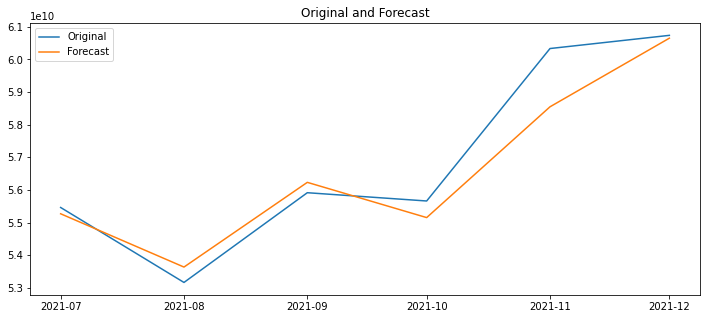

2007년도 부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 797022857.7396781


In [78]:
# 5개국 및 기타 변수 포함
plt.subplots(figsize=(12,5))

real_values = df['2021-07-01':]['total']
plt.plot(pred_index, real_values, label='Original')
plt.plot(pred_index, pred_values, label='Forecast')
plt.title('Original and Forecast')
plt.legend()
plt.show()

print('2007년도 부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : {}'.format(rmse))

# 최종 예측 (2022.01 - 2022.06) 


In [79]:
df = pd.read_csv('HTrain.csv')
df = df.set_index('date')

### 각 나라별 수출액 및 변수 예측 (2022.01 - 2022.06)

In [80]:
# 예측할 변수를 받는 함수 정의

def predict_exog(used_col):

  model = sm.tsa.statespace.SARIMAX(
    df[used_col],
    order = (1, 1, 0),
    seasonal_order = (1, 1, 1, 12),
    # AR 매개 변수를 변환하여 모델의 자동 회귀 구성 요소에서 정상 성을 강제 적용할지 여부
    enforce_stationarity = False,

    # 모델의 이동 평균 구성 요소에서 반전 성을 강제하기 위해 MA 매개 변수를 변환할지 여부
    enforce_invertibility = False)
  results = model.fit()

  forecast = results.get_forecast( steps = 6)

  pred_values = round(forecast.predicted_mean, 2)

  return pred_values

In [81]:
china = predict_exog('china')
usa = predict_exog('usa')
vietnam = predict_exog('vietnam')
hongkong = predict_exog('hongkong')
japan = predict_exog('japan')
korea_index = predict_exog('korea_index')
oil = predict_exog('oil')

In [82]:
# 예측한 값 데이터 프레임으로 저장

pred_arr = np.array((china, usa, vietnam, hongkong, japan, korea_index, oil))

cols = ['china', 'usa', 'vietnam', 'hongkong', 'japan', 'korea index', 'oil']

predicted_exog = pd.DataFrame(index=china.index, columns=cols)
predicted_exog.index.names = ['date']

for i in range(6):
  for q in range(7):
    predicted_exog.iloc[i][q] = pred_arr[q][i]

# 만든 데이터 프레임 csv파일로 저장
predicted_exog.to_csv('predicted_exog.csv')

### 위에서 예측한 변수로 최종 예측

In [83]:
df = pd.read_csv('HTrain.csv')
df = df.set_index('date')

total = df['total']
exog = df.drop('total', axis=1)


# 위에서 만든 csv 파일 불러오기
predicted_exog = pd.read_csv('/content/predicted_exog.csv')
predicted_exog = predicted_exog.set_index('date')

print('------------------------총 수출액---------------------')
print(total)
print('-------------------------변수------------------------ ')
print(exog)
print('-------------------------예측한 변수---------------------')
print(predicted_exog)

------------------------총 수출액---------------------
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
-------------------------변수------------------------ 
                  china         usa     vietnam    hongkong       japan  \
date                                                                      
2000-01-01   1235215271  2609787984   109742698   782348732  1551722070   
2000-02-01   1273117309  2554309883   112395157   823990122  1518844843   
2000-03-01   1437377223  2946820669   150134562   911648256  1783564618   
2000-04-01   1366876604  2698029849   169146208   863243219  1582707525   
2000-05-01   1663240667  3167181403   169411680   887081090  1671039709   
...                 ...         ...      

In [84]:
def predict_final(total, exog, predicted_exog, not_used_cols):
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

  
  model = SARIMAX(total[84:],
                  exog=exog[84:],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=predicted_exog)
  pred_values = pred.predicted_mean
  print('-----예측한 값------')
  print('')
  print('')
  return pred_values

In [85]:
pd.options.display.float_format = '{:.5f}'.format
predict_final(total, exog, predicted_exog, ['oecd_index','ex_rate'])

-----예측한 값------




2022-01-01   58111201525.08147
2022-02-01   55853527026.25778
2022-03-01   62938985888.76762
2022-04-01   60268974962.32507
2022-05-01   59209221110.11231
2022-06-01   61601237270.46964
Freq: MS, dtype: float64